Example notebook to showcase the use of the eccDefinition module. Please do not commit your local changes

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

import sys
sys.path.append("../")

from measureEccentricity.measureEccentricity import get_available_methods
from measureEccentricity import measure_eccentricity
from measureEccentricity.load_data import load_waveform

%load_ext autoreload
%autoreload 2

/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


Let's start by seeing which methods are currently implemented

In [2]:
available_methods = list(get_available_methods().keys())
print (available_methods)

['Amplitude', 'Frequency', 'ResidualAmplitude']


In the following, we will use these different methods and show what the measured eccentricity looks like. The wrapper function, measure_eccentricity, allows you to easily switch between methods.

In [3]:
help(measure_eccentricity)

Help on function measure_eccentricity in module measureEccentricity.measureEccentricity:

measure_eccentricity(tref_in, dataDict, method='Amplitude', return_ecc_method=False, extrema_finding_keywords=None, spline_keywords=None, extra_keywprds=None)
    Measure eccentricity and mean anomaly at reference time.
    
    parameters:
    ----------
    tref_in:
        Input Reference time at which to measure eccentricity and mean anomaly.
        Can be a single float or an array.
    
    dataDict:
        Dictionary containing waveform modes dict, time etc.
        Should follow the format:
            {"t": time, "hlm": modeDict, ...}
            with modeDict = {(l1, m1): h_{l1, m1},
                             (l2, m2): h_{l2, m2}, ...
                            }.
        Some methods may need extra data. For example, the ResidualAmplitude
        method, requires "t_zeroecc" and "hlm_zeroecc" as well in dataDict.
    
    method:
        method to define eccentricity. See get_avai

### Loading waveform data

Let's now get some waveform data in the required format, using the handy load_waveform function.

In [4]:
help(load_waveform)

Help on function load_waveform in module measureEccentricity.load_data:

load_waveform(catalog='LAL', file=None, nr_modelist=[[2, 2]], **kwargs)
    Load waveform from file or LAL
    
    parameters:
    ----------
    catalog:
          Waveform type. could be one of 'LAL', 'EOB', 'SXS', 'ET'
    
    file:
         Path to file for waveform to be read from a file. This is required for
         catalog other than 'LAL'
    
    nr_modelist:
        List of modes to include when loading NR data from 'SXS' or 'ET'
    
    **kwargs:
        Keywords to generate LAL waveform.



In [5]:
# Let's try a PN eccentric model
# We use the keyword "include_zero_ecc" as we want to use the residual amplitude 
# method that needs data for the zero eccentricity counterpart as well
waveform_keywords = {"approximant": "EccentricTD",
                     "q": 1.0,
                     "chi1": [0.0, 0.0, 0.0],
                     "chi2": [0.0, 0.0, 0.0],
                     "deltaTOverM": 0.1,
                     "Momega0": 0.01,
                     "ecc": 0.1,
                     "mean_ano": 0,
                     "phi_ref": 0,
                     "inclination": 0,
                     "include_zero_ecc": True}
dataDict = load_waveform(**waveform_keywords)

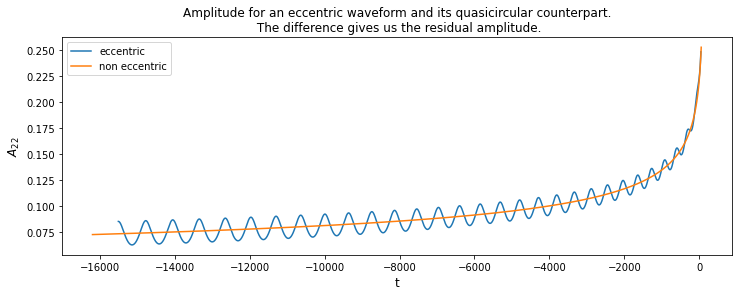

In [6]:
plt.figure(0, figsize=(12, 4))
plt.plot(dataDict["t"], np.abs(dataDict["hlm"][(2, 2)]), label="eccentric")
plt.plot(dataDict["t_zeroecc"], np.abs(dataDict["hlm_zeroecc"][(2, 2)]), label="non eccentric")
plt.xlabel('t', fontsize=12)
plt.ylabel('$A_{22}$', fontsize=12)
plt.title('Amplitude for an eccentric waveform and its quasicircular counterpart.\n '
          'The difference gives us the residual amplitude.')
plt.legend();

### Measure eccentricity at a given tref

In [7]:
# Use the measure_eccentricity with your favorite method to 
# compute ecc and mean_ano at a given tref
tref = -12000
tref_out, ecc, mean_ano = measure_eccentricity(tref, dataDict, method="Amplitude")
print (f"ecc={ecc:.3f} and mean_ano={mean_ano:.3f} at tref={tref}")

ecc=0.104 and mean_ano=5.951 at tref=-12000


### Now try all available methods

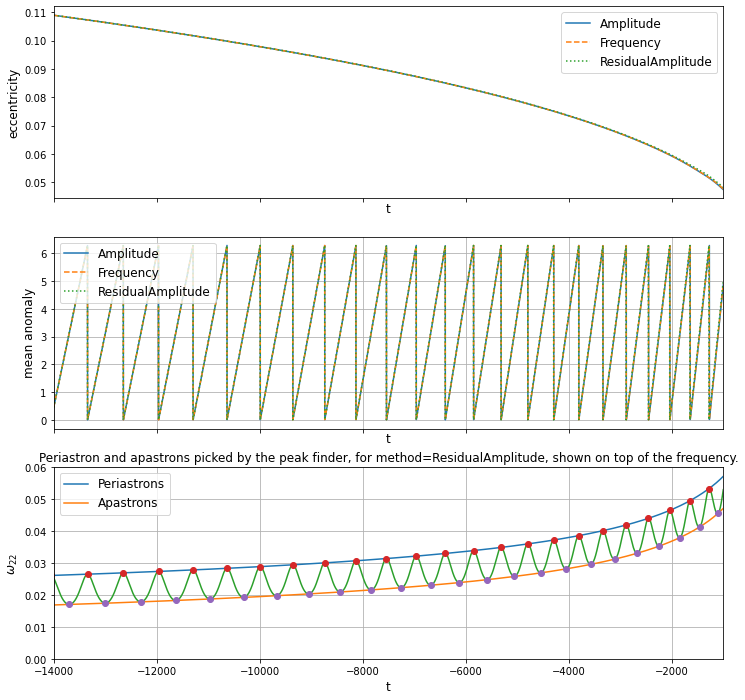

In [8]:
# refernce times at which to measure eccentricity and mean anomaly
tref_vec = np.arange(-14000, -1000)

fig, axarr = plt.subplots(nrows=3, sharex=True, figsize=(12, 12))
for method in available_methods:
    tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_vec, dataDict, method=method, return_ecc_method=True)
    if method == available_methods[0]:
        ls = 'solid'
    elif method == available_methods[1]:
        ls = 'dashed'
    else:
        ls = 'dotted'
    axarr[0].plot(tref_vec, ecc_vec, label=method, ls=ls)
    axarr[1].plot(tref_vec, mean_ano_vec, label=method, ls=ls)
    
    if method == available_methods[-1]:
        # Plot omega(t) and peaks/troughs only for one case
        axarr[2].plot(tref_out, eccMethod.omega_peak_at_tref_out, label='Periastrons')
        axarr[2].plot(tref_out, eccMethod.omega_trough_at_tref_out, label='Apastrons')
        axarr[2].plot(eccMethod.t, eccMethod.omega22)
        axarr[2].plot(eccMethod.t[eccMethod.peaks_location], 
                      eccMethod.omega22[eccMethod.peaks_location], marker="o", ls="")
        axarr[2].plot(eccMethod.t[eccMethod.troughs_location], 
                      eccMethod.omega22[eccMethod.troughs_location], marker="o", ls="")
        axarr[2].set_title('Periastron and apastrons picked by the peak finder, '
                            f'for method={method}, shown on top of the frequency.', fontsize=12);

axarr[0].set_xlabel("t", fontsize=12)
axarr[1].set_xlabel("t", fontsize=12)
axarr[0].set_ylabel("eccentricity", fontsize=12)
axarr[1].set_ylabel("mean anomaly", fontsize=12)
axarr[1].grid()
axarr[0].legend(fontsize=12)
axarr[1].legend(fontsize=12)
axarr[2].set_ylim(0, 0.06)
axarr[2].set_xlim(min(tref_vec), max(tref_vec))
axarr[2].set_xlabel("t", fontsize=12)
axarr[2].set_ylabel("$\omega_{22}$", fontsize=12)
axarr[2].grid()
axarr[2].legend(fontsize=12);